In [2]:
is_Ubuntu = True

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
import tensorflow as tf
import tensorflow
from tensorflow import keras
%matplotlib inline

if is_Ubuntu:
    H_Wildfires = pd.read_csv(r'../data/Nov_10/Historical_Wildfires.csv')
    H_Weather = pd.read_csv(r'../data/Nov_10/HistoricalWeather.csv')
    H_Weather_Fc = pd.read_csv(r'../data/Nov_10/HistoricalWeatherForecasts.csv')
    LandClass = pd.read_csv(r'../data/Nov_10/LandClass.csv')
    Vege = pd.read_csv(r'../data/Nov_10/VegetationIndex.csv')
    Sample = pd.read_csv(r'../data/submission-example.csv')
else:
    H_Wildfires = pd.read_csv(r'..\data\Nov_10\Historical_Wildfires.csv')
    H_Weather = pd.read_csv(r'..\data\Nov_10\HistoricalWeather.csv')
    H_Weather_Fc = pd.read_csv(r'..\data\Nov_10\HistoricalWeatherForecasts.csv')
    LandClass = pd.read_csv(r'..\data\Nov_10\LandClass.csv')
    Vege = pd.read_csv(r'..\data\Nov_10\VegetationIndex.csv')
    Sample = pd.read_csv(r'..\data\submission-example.csv')

one of two input will be necessary in Std&Var to improve computation
I will keep Var and discard Std

In [3]:
H_Wildfires = H_Wildfires.dropna() 
H_Wildfires=H_Wildfires.drop(columns='Std_confidence')

In [4]:
def reform(df, target_column, common_cols, key_cols, param_cols):
    elements = df[target_column].unique()
    basis = df[common_cols].drop_duplicates()
    for elm in elements:
        new = df[df[target_column] == elm][key_cols + param_cols]
        rename = {}
        for col in param_cols:
            rename[col] = str(elm) + '_' + col
        new = new.rename(columns=rename)
        basis = basis.merge(new, on=key_cols)
    return basis

In [5]:
target_column = 'Parameter'
common_cols = ['Date', 'Region', 'count()[unit: km^2]']
common_cols_fc = ['Date', 'Region', 'Lead time', 'count()[unit: km^2]']
key_cols = ['Date', 'Region']
key_cols_fc = ['Date', 'Region', 'Lead time']
param_cols = ['min()', 'max()', 'mean()', 'variance()']

H_Weather_reform = reform(H_Weather.copy(), target_column, common_cols, key_cols, param_cols)
H_Weather_Fc_reform = reform(H_Weather_Fc.copy(), target_column, common_cols_fc, key_cols_fc, param_cols)

In [6]:
ohe = OneHotEncoder(sparse=False)
ohe.fit_transform(H_Weather_reform[['Region']])

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [7]:
column_trans = make_column_transformer(
(OneHotEncoder(),['Region']), remainder='passthrough')
Weather_ohe1=column_trans.fit_transform(H_Weather_reform)
# now Region is transformed into one-hot encoder.

In [8]:
column_wo_Region=np.delete(H_Weather_reform.columns.values,1)

In [9]:
Weather_ohe=pd.DataFrame(Weather_ohe1,columns=np.concatenate((np.squeeze(np.array(ohe.categories_)),column_wo_Region)))
Weather_ohe=Weather_ohe.reindex(columns=['Date','NSW', 'NT', 'QL', 'SA', 'TA', 'VI', 'WA','count()[unit: km^2]', 'Precipitation_min()',
       'Precipitation_max()', 'Precipitation_mean()',
       'Precipitation_variance()', 'RelativeHumidity_min()',
       'RelativeHumidity_max()', 'RelativeHumidity_mean()',
       'RelativeHumidity_variance()', 'SoilWaterContent_min()',
       'SoilWaterContent_max()', 'SoilWaterContent_mean()',
       'SoilWaterContent_variance()', 'SolarRadiation_min()',
       'SolarRadiation_max()', 'SolarRadiation_mean()',
       'SolarRadiation_variance()', 'Temperature_min()', 'Temperature_max()',
       'Temperature_mean()', 'Temperature_variance()', 'WindSpeed_min()',
       'WindSpeed_max()', 'WindSpeed_mean()', 'WindSpeed_variance()'])

In [10]:
ohe2 = OneHotEncoder(sparse=False)
ohe2.fit_transform(H_Wildfires[['Region']])
column_trans = make_column_transformer(
(OneHotEncoder(),['Region']), remainder='passthrough')
H_Wildfires_ohe2=column_trans.fit_transform(H_Wildfires.copy())
# now Region is transformed into one-hot encoder.
H_Wildfires_ohe2
column_wo_Region2=np.delete(H_Wildfires.columns.values,0) # if the wrong column is deleted, change 0 to proper column.
H_Wildfires_ohe=pd.DataFrame(H_Wildfires_ohe2,columns=np.concatenate((np.squeeze(np.array(ohe2.categories_)),column_wo_Region2)))

In [11]:
H_Wildfires_ohe=H_Wildfires_ohe.drop(columns=['Replaced'])
# Delete Replaced. I believe it has no impact for the result.

In [12]:
H_Wildfires_ohe.Date=pd.to_datetime(H_Wildfires_ohe.Date)
Weather_ohe.Date=pd.to_datetime(Weather_ohe.Date)

In [13]:
Weather_ohe.iloc[24,0]==H_Wildfires_ohe.iloc[0,7] # It's same now.

True

In [14]:
Input = pd.merge(H_Wildfires_ohe, Weather_ohe, how='inner', on=['Date','NSW', 'NT', 'QL', 'SA', 'TA', 'VI', 'WA'])
Input = Input.sort_values(['Date'])

12 Dec. Use only one region's data, to see the performance of different models. Choose region WA because it has the most data.

In [56]:
df = Input[Input.WA == 1]
drop_columns = ['Date']
for col in df.columns: # avoid deviding by zero during normalization
    if df[col].max()==df[col].min():
        drop_columns.append(col)
df = df.drop(columns = drop_columns)
df=(df-df.min())/(df.max()-df.min())  # Normalization

num_features = df.shape[1]

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

df.head()

,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,Mean_confidence,Var_confidence,Count,Precipitation_min(),Precipitation_max(),Precipitation_mean(),Precipitation_variance(),...,SolarRadiation_mean(),SolarRadiation_variance(),Temperature_min(),Temperature_max(),Temperature_mean(),Temperature_variance(),WindSpeed_min(),WindSpeed_max(),WindSpeed_mean(),WindSpeed_variance()
18623,0.00406928,0.331787,0.0876675,0.761607,0.159708,0.00379713,0,0.250661,0.0841186,0.0499457,...,0.800966,0.204583,0.802755,0.750717,0.742997,0.251742,0.153101,0.370355,0.314047,0.129569
18624,0.0172922,0.448162,0.557702,0.652101,0.248267,0.00867914,0,0.145046,0.0948162,0.0377484,...,0.79328,0.307629,0.606944,0.82525,0.750002,0.42676,0.343396,0.486709,0.384286,0.276758
18625,0.00693931,0.443454,0.112588,0.693088,0.190995,0.00786547,0,0.0669172,0.0382628,0.00860089,...,0.868959,0.293068,0.676923,0.837893,0.707278,0.536578,0.553501,0.433362,0.472652,0.161515
18626,0.00998595,0.420081,0.0955799,0.55119,0.230652,0.00922159,0,0.0188217,0.00697264,0.000380184,...,0.917756,0.157205,0.665563,0.827953,0.697926,0.383469,0.568178,0.390021,0.415425,0.0639487
18627,0.00347709,0.610083,0.143257,0.810526,0.0965724,0.00461079,0,0.00794452,0.00274197,7.13268e-05,...,0.93437,0.0954781,0.66676,0.75,0.728099,0.364159,0.319461,0.206069,0.355229,0.0552421


In [16]:
# df = Input.drop(columns = ['Date'])
# num_features = df.shape[1]

# n = len(df)
# train_df = df[0:int(n*0.7)]
# val_df = df[int(n*0.7):int(n*0.9)]
# test_df = df[int(n*0.9):]

# df.astype(float)

# # train_mean = train_df.mean()
# # train_std = train_df.std()

# # train_df = (train_df - train_mean) / train_std
# # val_df = (val_df - train_mean) / train_std
# # test_df = (test_df - train_mean) / train_std

simple model (test)

In [17]:
# df = pd.DataFrame({'A': np.linspace(0.0, 100.0, num=301), 'B': np.linspace(0.0, 100, num=301), 'Estimated_fire_area': np.linspace(0, 200, num=301)})
# num_features = df.shape[1]

# n = len(df)
# train_df = df[0:int(n*0.7)]
# val_df = df[int(n*0.7):int(n*0.9)]
# test_df = df[int(n*0.9):]

# test_df.head()

## 1. Indexex and offsets

In [57]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=['Estimated_fire_area']):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

## 2. Split

In [58]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

## 3. Plot

In [59]:
def plot(self, model=None, plot_col='Estimated_fire_area', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Day')

WindowGenerator.plot = plot

## 4. Create tf.data.Datasets

In [60]:
def make_dataset(self, data):
    
  data = np.array(data, dtype=np.float32)    
#   data1 = np.array(data.drop(columns='Estimated_fire_area'), dtype=np.float32)
#   targets = np.array(data['Estimated_fire_area'], dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,  # If this is 7, Could it work as daily moving???
      shuffle=False,
      batch_size=16,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [61]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    print('No example batch was found, so get one from the `.train` dataset')
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [77]:
# MAX_EPOCHS = 200

def compile_and_fit(model, window, patience=300, epochs=100):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])
    
    history = model.fit(window.train, epochs=epochs,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

val_performance = {}
performance = {}

No example batch was found, so get one from the `.train` dataset


Total window size: 59
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]
Label indices: [31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54
 55 56 57 58]
Label column name(s): ['Estimated_fire_area']

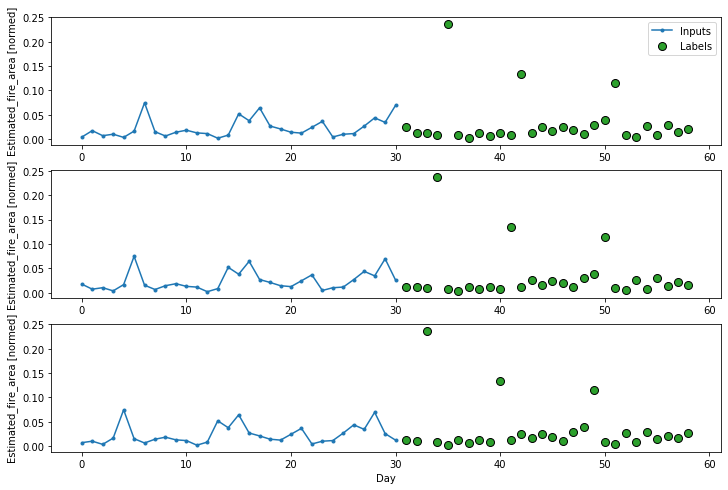

In [63]:
# WA region data
OUT_STEPS = 28
multi_window = WindowGenerator(input_width=31,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,label_columns=['Estimated_fire_area'],
                              train_df=train_df, val_df=val_df, test_df=test_df,)

multi_window.plot()
multi_window

In [64]:
# Each element is an (inputs, label) pair
multi_window.train.element_spec

(TensorSpec(shape=(None, 31, 30), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 28, 1), dtype=tf.float32, name=None))

In [65]:
def plot_history(history_object, plot_columns = ['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error']):
    fig_num = len(plot_columns)
    plt.figure(figsize=(12, 8))
    for n in range(fig_num):
        plt.subplot(fig_num, 1, n+1)
        plt.ylabel(plot_columns[n])
        plt.plot(history_object.history[plot_columns[n]])

In [66]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.Dense(20),
    tf.keras.layers.GRU(50, return_sequences=True, return_state=False),
    tf.keras.layers.GRU(50), 
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS,
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS,1])
                          )])

Epoch 1/300
239/239 [==============================] - 8s 34ms/step - loss: 7.0620e-04 - mean_absolute_error: 0.0175 - val_loss: 0.0036 - val_mean_absolute_error: 0.0289
Epoch 2/300
239/239 [==============================] - 7s 30ms/step - loss: 8.2184e-04 - mean_absolute_error: 0.0186 - val_loss: 0.0034 - val_mean_absolute_error: 0.0286
Epoch 3/300
239/239 [==============================] - 7s 31ms/step - loss: 6.9414e-04 - mean_absolute_error: 0.0174 - val_loss: 0.0037 - val_mean_absolute_error: 0.0293
Epoch 4/300
239/239 [==============================] - 7s 31ms/step - loss: 6.5152e-04 - mean_absolute_error: 0.0163 - val_loss: 0.0031 - val_mean_absolute_error: 0.0285
Epoch 5/300
239/239 [==============================] - 7s 31ms/step - loss: 6.4423e-04 - mean_absolute_error: 0.0163 - val_loss: 0.0034 - val_mean_absolute_error: 0.0291
Epoch 6/300
239/239 [==============================] - 8s 32ms/step - loss: 6.4469e-04 - mean_absolute_error: 0.0165 - val_loss: 0.0034 - val_mean_abs

Epoch 49/300
239/239 [==============================] - 6s 26ms/step - loss: 4.3423e-04 - mean_absolute_error: 0.0137 - val_loss: 0.0035 - val_mean_absolute_error: 0.0299
Epoch 50/300
239/239 [==============================] - 6s 26ms/step - loss: 4.1048e-04 - mean_absolute_error: 0.0135 - val_loss: 0.0033 - val_mean_absolute_error: 0.0300
Epoch 51/300
239/239 [==============================] - 6s 26ms/step - loss: 4.0438e-04 - mean_absolute_error: 0.0133 - val_loss: 0.0033 - val_mean_absolute_error: 0.0295
Epoch 52/300
239/239 [==============================] - 7s 30ms/step - loss: 4.1149e-04 - mean_absolute_error: 0.0137 - val_loss: 0.0036 - val_mean_absolute_error: 0.0311
Epoch 53/300
239/239 [==============================] - 6s 26ms/step - loss: 4.3309e-04 - mean_absolute_error: 0.0143 - val_loss: 0.0033 - val_mean_absolute_error: 0.0299
Epoch 54/300
239/239 [==============================] - 6s 27ms/step - loss: 4.5222e-04 - mean_absolute_error: 0.0143 - val_loss: 0.0035 - val_me

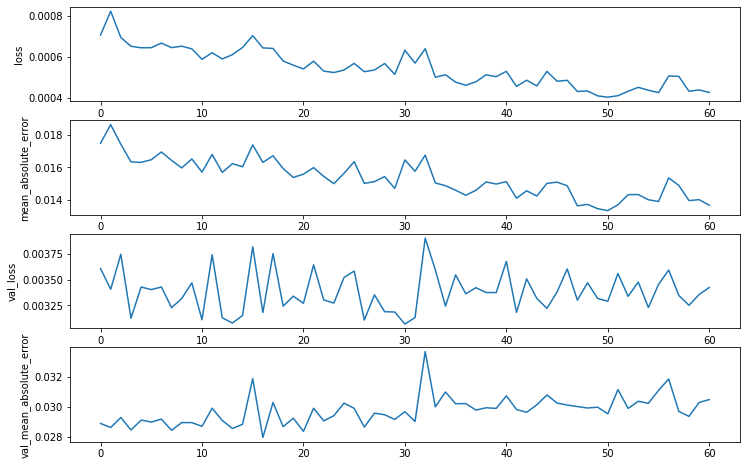

In [68]:
history2 = compile_and_fit(multi_lstm_model, multi_window, epochs=300)
plot_history(history2)

In [32]:
multi_lstm_model.predict(multi_window.val)

When I change to GRU instead of LSTM, it works better.

66/66 [==============================] - 1s 8ms/step - loss: 0.0034 - mean_absolute_error: 0.0305


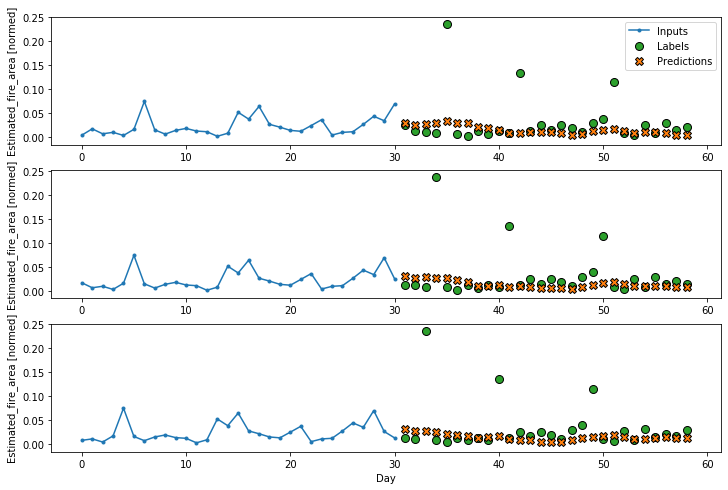

In [82]:
val_performance['M_LSTM'] = multi_lstm_model.evaluate(multi_window.val)
performance['M_LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

Epoch 1/100
239/239 [==============================] - 2s 8ms/step - loss: 0.0024 - mean_absolute_error: 0.0267 - val_loss: 0.0035 - val_mean_absolute_error: 0.0317
Epoch 2/100
239/239 [==============================] - 2s 6ms/step - loss: 0.0023 - mean_absolute_error: 0.0264 - val_loss: 0.0034 - val_mean_absolute_error: 0.0332
Epoch 3/100
239/239 [==============================] - 2s 6ms/step - loss: 0.0023 - mean_absolute_error: 0.0265 - val_loss: 0.0034 - val_mean_absolute_error: 0.0328
Epoch 4/100
239/239 [==============================] - 2s 6ms/step - loss: 0.0023 - mean_absolute_error: 0.0263 - val_loss: 0.0033 - val_mean_absolute_error: 0.0323
Epoch 5/100
239/239 [==============================] - 2s 7ms/step - loss: 0.0023 - mean_absolute_error: 0.0262 - val_loss: 0.0034 - val_mean_absolute_error: 0.0321
Epoch 6/100
239/239 [==============================] - 2s 8ms/step - loss: 0.0023 - mean_absolute_error: 0.0262 - val_loss: 0.0034 - val_mean_absolute_error: 0.0328
Epoch 7/10

239/239 [==============================] - 1s 5ms/step - loss: 0.0023 - mean_absolute_error: 0.0264 - val_loss: 0.0034 - val_mean_absolute_error: 0.0328
Epoch 51/100
239/239 [==============================] - 1s 5ms/step - loss: 0.0023 - mean_absolute_error: 0.0264 - val_loss: 0.0034 - val_mean_absolute_error: 0.0328
Epoch 52/100
239/239 [==============================] - 1s 5ms/step - loss: 0.0023 - mean_absolute_error: 0.0264 - val_loss: 0.0034 - val_mean_absolute_error: 0.0328
Epoch 53/100
239/239 [==============================] - 1s 5ms/step - loss: 0.0023 - mean_absolute_error: 0.0264 - val_loss: 0.0034 - val_mean_absolute_error: 0.0328
Epoch 54/100
239/239 [==============================] - 1s 5ms/step - loss: 0.0023 - mean_absolute_error: 0.0264 - val_loss: 0.0034 - val_mean_absolute_error: 0.0328
Epoch 55/100
239/239 [==============================] - 1s 5ms/step - loss: 0.0023 - mean_absolute_error: 0.0264 - val_loss: 0.0034 - val_mean_absolute_error: 0.0328
Epoch 56/100
239/

239/239 [==============================] - 1s 5ms/step - loss: 0.0023 - mean_absolute_error: 0.0264 - val_loss: 0.0034 - val_mean_absolute_error: 0.0328
Epoch 100/100
239/239 [==============================] - 1s 5ms/step - loss: 0.0023 - mean_absolute_error: 0.0264 - val_loss: 0.0034 - val_mean_absolute_error: 0.0328


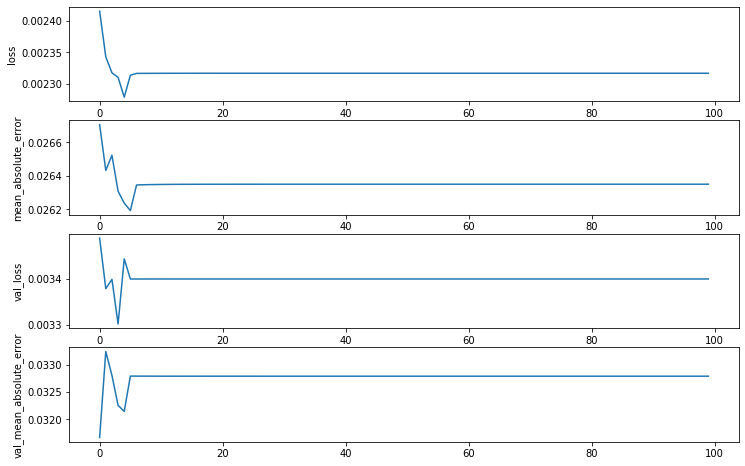

In [78]:
CONV_WIDTH = 28
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*1,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

history = compile_and_fit(multi_conv_model, multi_window, epochs=100)
plot_history(history)

In [35]:
multi_conv_model.predict(multi_window.val)

66/66 [==============================] - 0s 3ms/step - loss: 0.0034 - mean_absolute_error: 0.0328


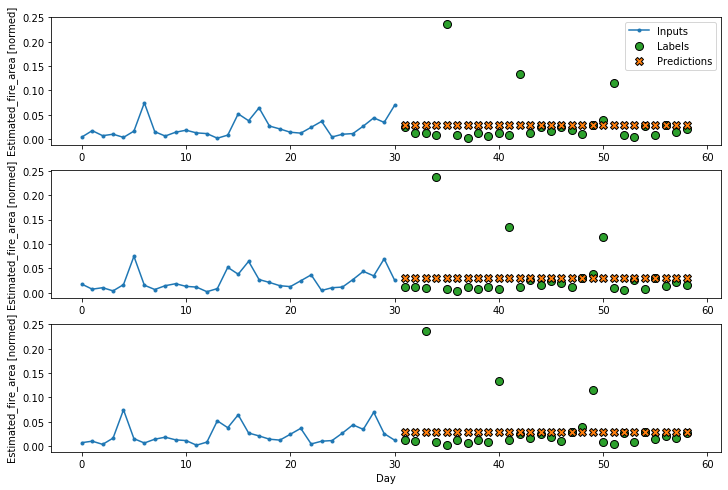

In [79]:
val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

Try Autoregressive model

In [72]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)
    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state
    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the lstm state
        prediction, state = self.warmup(inputs)

        # Insert the first prediction
        predictions.append(prediction)

        # Run the rest of the prediction steps
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.lstm_cell(x, states=state,
                                      training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions


In [73]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)
prediction, state = feedback_model.warmup(multi_window.example[0])
print('prediction.shape', prediction.shape)
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

prediction.shape (16, 30)
Output shape (batch, time, features):  (16, 28, 30)


Epoch 1/200
239/239 [==============================] - 4s 19ms/step - loss: 0.0026 - mean_absolute_error: 0.0284 - val_loss: 0.0035 - val_mean_absolute_error: 0.0318
Epoch 2/200
239/239 [==============================] - 4s 18ms/step - loss: 0.0023 - mean_absolute_error: 0.0264 - val_loss: 0.0034 - val_mean_absolute_error: 0.0315
Epoch 3/200
239/239 [==============================] - 4s 17ms/step - loss: 0.0023 - mean_absolute_error: 0.0262 - val_loss: 0.0034 - val_mean_absolute_error: 0.0313
Epoch 4/200
239/239 [==============================] - 4s 18ms/step - loss: 0.0023 - mean_absolute_error: 0.0260 - val_loss: 0.0033 - val_mean_absolute_error: 0.0310
Epoch 5/200
239/239 [==============================] - 5s 19ms/step - loss: 0.0022 - mean_absolute_error: 0.0259 - val_loss: 0.0033 - val_mean_absolute_error: 0.0307
Epoch 6/200
239/239 [==============================] - 5s 20ms/step - loss: 0.0022 - mean_absolute_error: 0.0257 - val_loss: 0.0032 - val_mean_absolute_error: 0.0307
Epoc

239/239 [==============================] - 4s 17ms/step - loss: 0.0018 - mean_absolute_error: 0.0225 - val_loss: 0.0027 - val_mean_absolute_error: 0.0269
Epoch 51/200
239/239 [==============================] - 4s 18ms/step - loss: 0.0017 - mean_absolute_error: 0.0217 - val_loss: 0.0028 - val_mean_absolute_error: 0.0270
Epoch 52/200
239/239 [==============================] - 4s 18ms/step - loss: 0.0016 - mean_absolute_error: 0.0210 - val_loss: 0.0028 - val_mean_absolute_error: 0.0271
Epoch 53/200
239/239 [==============================] - 4s 18ms/step - loss: 0.0016 - mean_absolute_error: 0.0207 - val_loss: 0.0031 - val_mean_absolute_error: 0.0291
Epoch 54/200
239/239 [==============================] - 4s 19ms/step - loss: 0.0016 - mean_absolute_error: 0.0214 - val_loss: 0.0029 - val_mean_absolute_error: 0.0276
Epoch 55/200
239/239 [==============================] - 5s 22ms/step - loss: 0.0018 - mean_absolute_error: 0.0216 - val_loss: 0.0027 - val_mean_absolute_error: 0.0265
Epoch 56/20

239/239 [==============================] - 4s 16ms/step - loss: 0.0013 - mean_absolute_error: 0.0194 - val_loss: 0.0035 - val_mean_absolute_error: 0.0308
Epoch 100/200
239/239 [==============================] - 4s 16ms/step - loss: 0.0012 - mean_absolute_error: 0.0194 - val_loss: 0.0029 - val_mean_absolute_error: 0.0288
Epoch 101/200
239/239 [==============================] - 4s 16ms/step - loss: 0.0012 - mean_absolute_error: 0.0192 - val_loss: 0.0041 - val_mean_absolute_error: 0.0328
Epoch 102/200
239/239 [==============================] - 4s 18ms/step - loss: 0.0012 - mean_absolute_error: 0.0193 - val_loss: 0.0027 - val_mean_absolute_error: 0.0275
Epoch 103/200
239/239 [==============================] - 5s 20ms/step - loss: 0.0012 - mean_absolute_error: 0.0193 - val_loss: 0.0027 - val_mean_absolute_error: 0.0274
Epoch 104/200
239/239 [==============================] - 6s 25ms/step - loss: 0.0012 - mean_absolute_error: 0.0192 - val_loss: 0.0031 - val_mean_absolute_error: 0.0292
Epoch 

Epoch 148/200
239/239 [==============================] - 4s 15ms/step - loss: 0.0013 - mean_absolute_error: 0.0195 - val_loss: 0.0035 - val_mean_absolute_error: 0.0316


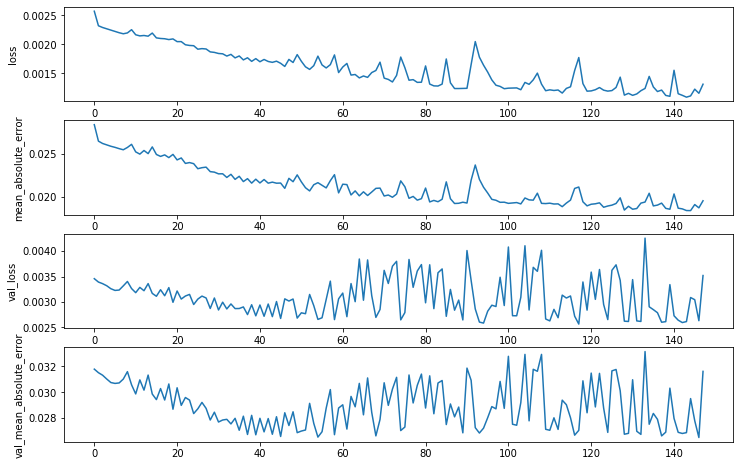

In [74]:
history_ar = compile_and_fit(feedback_model, multi_window, epochs=200)
plot_history(history_ar)

66/66 [==============================] - 0s 6ms/step - loss: 0.0035 - mean_absolute_error: 0.0316


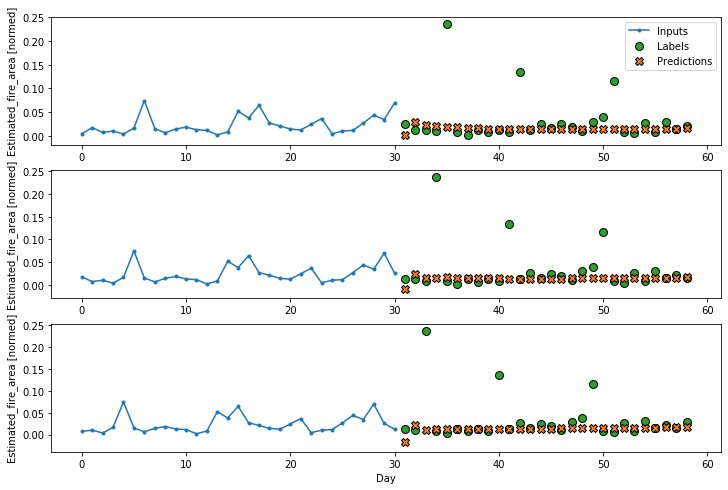

In [81]:
val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

Epoch 1/100
239/239 [==============================] - 18s 74ms/step - loss: 0.0042 - mean_absolute_error: 0.0401 - val_loss: 0.0037 - val_mean_absolute_error: 0.0345
Epoch 2/100
239/239 [==============================] - 16s 69ms/step - loss: 0.0025 - mean_absolute_error: 0.0286 - val_loss: 0.0033 - val_mean_absolute_error: 0.0311
Epoch 3/100
239/239 [==============================] - 16s 66ms/step - loss: 0.0023 - mean_absolute_error: 0.0267 - val_loss: 0.0032 - val_mean_absolute_error: 0.0301
Epoch 4/100
239/239 [==============================] - 17s 73ms/step - loss: 0.0024 - mean_absolute_error: 0.0278 - val_loss: 0.0032 - val_mean_absolute_error: 0.0294
Epoch 5/100
239/239 [==============================] - 19s 78ms/step - loss: 0.0022 - mean_absolute_error: 0.0266 - val_loss: 0.0034 - val_mean_absolute_error: 0.0313
Epoch 6/100
239/239 [==============================] - 18s 77ms/step - loss: 0.0023 - mean_absolute_error: 0.0273 - val_loss: 0.0032 - val_mean_absolute_error: 0.030

Epoch 50/100
239/239 [==============================] - 21s 88ms/step - loss: 0.0022 - mean_absolute_error: 0.0261 - val_loss: 0.0032 - val_mean_absolute_error: 0.0304
Epoch 51/100
239/239 [==============================] - 15s 63ms/step - loss: 0.0020 - mean_absolute_error: 0.0239 - val_loss: 0.0035 - val_mean_absolute_error: 0.0316
Epoch 52/100
239/239 [==============================] - 14s 59ms/step - loss: 0.0021 - mean_absolute_error: 0.0251 - val_loss: 0.0034 - val_mean_absolute_error: 0.0313
Epoch 53/100
239/239 [==============================] - 13s 55ms/step - loss: 0.0020 - mean_absolute_error: 0.0248 - val_loss: 0.0032 - val_mean_absolute_error: 0.0297
Epoch 54/100
239/239 [==============================] - 12s 51ms/step - loss: 0.0019 - mean_absolute_error: 0.0234 - val_loss: 0.0032 - val_mean_absolute_error: 0.0301
Epoch 55/100
239/239 [==============================] - 15s 64ms/step - loss: 0.0019 - mean_absolute_error: 0.0235 - val_loss: 0.0033 - val_mean_absolute_error:

Epoch 99/100
239/239 [==============================] - 18s 76ms/step - loss: 0.0014 - mean_absolute_error: 0.0199 - val_loss: 0.0026 - val_mean_absolute_error: 0.0264
Epoch 100/100
239/239 [==============================] - 15s 61ms/step - loss: 0.0013 - mean_absolute_error: 0.0195 - val_loss: 0.0029 - val_mean_absolute_error: 0.0274


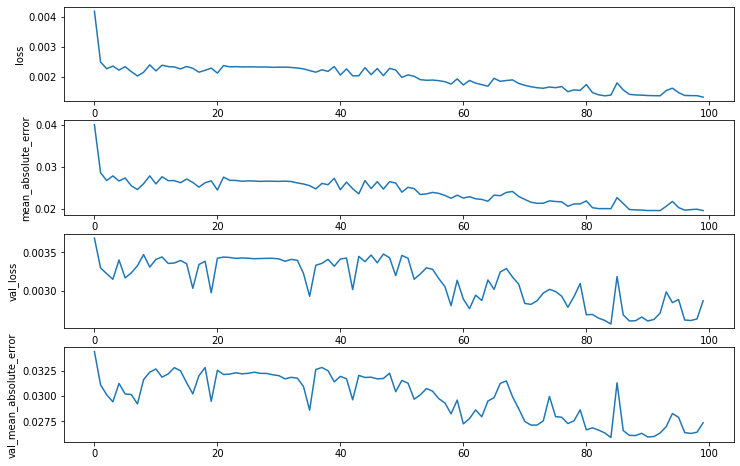

In [89]:
# ref:
# https://towardsdatascience.com/using-lstm-autoencoders-on-multidimensional-time-series-data-f5a7a51b29a1
# https://machinelearningmastery.com/lstm-autoencoders/
window_length = 31
output_length = 28
feats = 30
autoencoder_model = tf.keras.Sequential([
    keras.layers.LSTM(64, kernel_initializer='he_uniform', batch_input_shape=(None, window_length, feats), return_sequences=True, name='encoder_1'),
    keras.layers.LSTM(32, kernel_initializer='he_uniform', return_sequences=True, name='encoder_2'),
    keras.layers.LSTM(16, kernel_initializer='he_uniform', return_sequences=False, name='encoder_3'), 
    keras.layers.RepeatVector(output_length, name='encoder_decoder_bridge'),
    keras.layers.LSTM(16, kernel_initializer='he_uniform', return_sequences=True, name='decoder_1'),
    keras.layers.LSTM(32, kernel_initializer='he_uniform', return_sequences=True, name='decoder_2'),
    keras.layers.LSTM(64, kernel_initializer='he_uniform', return_sequences=True, name='decoder_3'),
    keras.layers.TimeDistributed(keras.layers.Dense(feats))
                          ])
# autoencoder_model = keras.Sequential()
# autoencoder_model.add(keras.layers.LSTM(64, kernel_initializer='he_uniform', batch_input_shape=(None, window_length, feats), return_sequences=True, name='encoder_1'))
# autoencoder_model.add(keras.layers.LSTM(32, kernel_initializer='he_uniform', return_sequences=True, name='encoder_2'))
# autoencoder_model.add(keras.layers.LSTM(16, kernel_initializer='he_uniform', return_sequences=False, name='encoder_3'))
# autoencoder_model.add(keras.layers.RepeatVector(window_length, name='encoder_decoder_bridge'))
# autoencoder_model.add(keras.layers.LSTM(16, kernel_initializer='he_uniform', return_sequences=True, name='decoder_1'))
# autoencoder_model.add(keras.layers.LSTM(32, kernel_initializer='he_uniform', return_sequences=True, name='decoder_2'))
# autoencoder_model.add(keras.layers.LSTM(64, kernel_initializer='he_uniform', return_sequences=True, name='decoder_3'))
# autoencoder_model.add(keras.layers.TimeDistributed(keras.layers.Dense(feats)))
# autoencoder_model.compile(loss="mse",optimizer='adam')
# autoencoder_model.build()
# print(autoencoder_model.summary())

# autoencoder_model.fit(x=X, y=Y, validation_data=(XX, YY), epochs=100, batch_size=batch_size, shuffle=True, callbacks=[early_stop])
history_encode = compile_and_fit(autoencoder_model, multi_window, epochs=100)
plot_history(history_encode)

66/66 [==============================] - 1s 16ms/step - loss: 0.0029 - mean_absolute_error: 0.0274


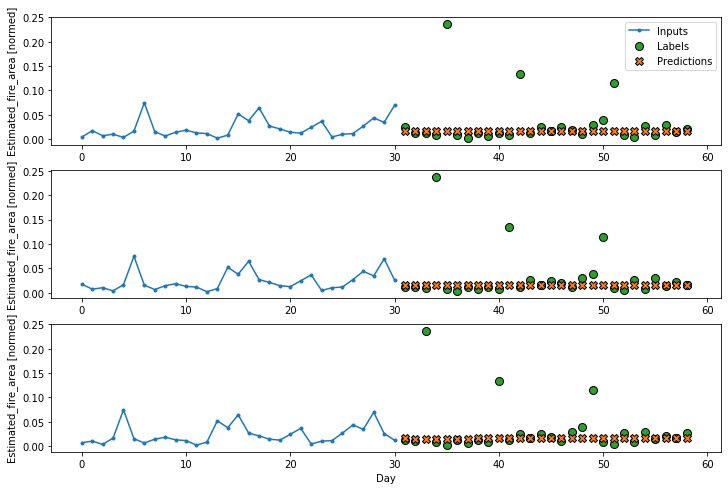

In [90]:
val_performance['Encoder'] = autoencoder_model.evaluate(multi_window.val)
performance['Encoder'] = autoencoder_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(autoencoder_model)

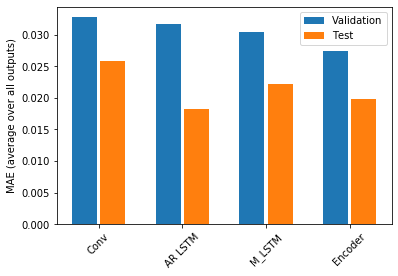

In [91]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [37]:
for example_inputs, example_labels in multi_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (16, 5, 3)
Labels shape (batch, time, features): (16, 5, 1)
